# Time Series Forecasting - Smoothing 

### Terminology and Notations

__A time series__ is a series of measurements of a particular phenomena taken over time.

__Time series forecasting__ refers to generating a future value for the series of interests.

 
> $t$ = 1,2,3,...   time period index

> $Y_{t}$ = value of a series at time period $t$

> $F_{t+k}$ = forecast for time period $t+k$, using data until time $t$ 

> $e_{t+k} = Y_{t+k}-F_{t+k} $= forecast error (residual) for period $t+k$

_def1_

__Level__ describes the average value of the series.

__Trend__ is the change in the series from one period to the next.

__Seasonality__ describes a short-term cyclical behavior of the series which can be observed several times within the given series.

__Noise__ is the random variation that results from measurement error or other causes not accounted for. It always present in a time series to some degree.

_def2_

__Level__: The average value in the series.

__Trend__: The increasing or decreasing value in the series.

__Seasonality__: The repeating short-term cycle in the series.

__Noise__: The random variation in the series.

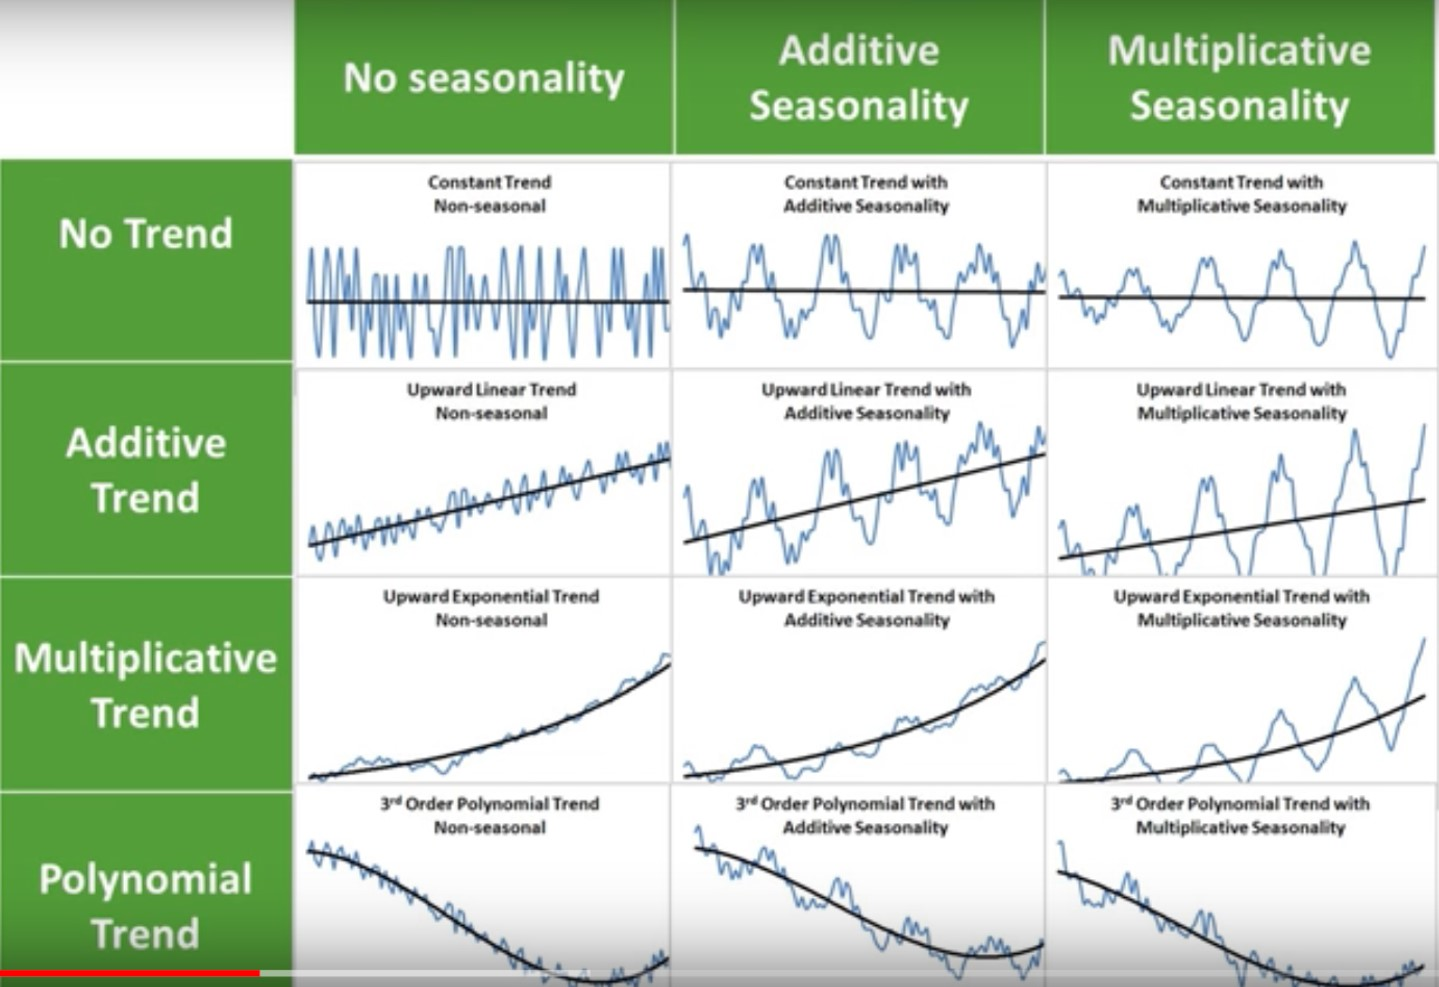

In [1]:
from IPython.display import Image

display(Image( "../imgs/trends-seasonality.jpg", 
              width = 100, 
              height = 100, 
              retina = True ))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
%reload_ext version_information
%version_information pandas, matplotlib

Software versions
Python 3.7.5 64bit [MSC v.1916 64 bit (AMD64)]
IPython 7.13.0
OS Windows 10 10.0.18362 SP0
pandas 0.25.3
matplotlib 3.1.1
Wed Apr 01 16:01:10 2020 W. Europe Daylight Time

In [4]:
mrt = pd.read_excel('../data/Taipei_MRT.xlsx', date_parser='Date')

In [5]:
mrt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7308 entries, 0 to 7307
Data columns (total 5 columns):
year            7308 non-null int64
month           7308 non-null int64
day_of_month    7308 non-null int64
Date            7308 non-null datetime64[ns]
count           7308 non-null int64
dtypes: datetime64[ns](1), int64(4)
memory usage: 285.6 KB


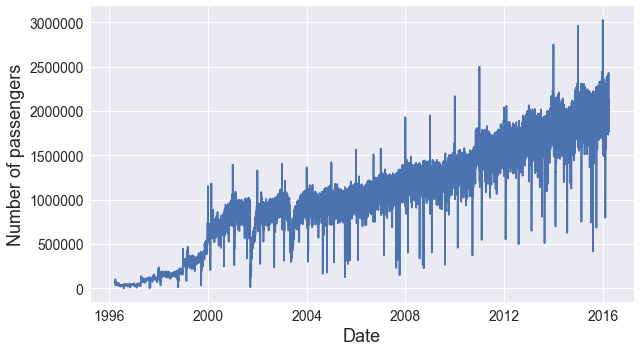

In [6]:
pd.plotting.register_matplotlib_converters()
plt.style.use('seaborn')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,5))

ax.plot(mrt['Date'], mrt['count'])
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Number of passengers', fontsize=18)

ax.tick_params(labelsize=14)

plt.tight_layout()
plt.show()
plt.close()

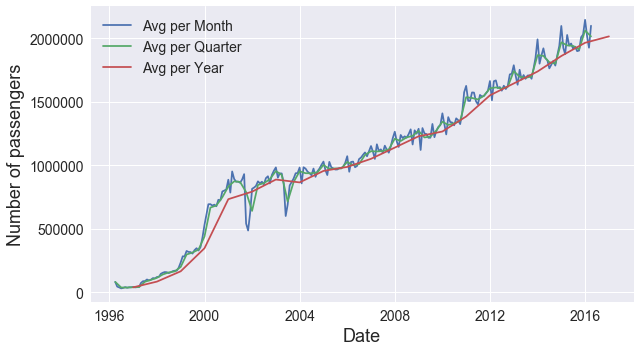

In [7]:
# an average number of passengers

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,5))

ax.plot(mrt.set_index('Date').resample('M')['count'].mean(), label='Avg per Month')
ax.plot(mrt.set_index('Date').resample('Q')['count'].mean(), label='Avg per Quarter')
ax.plot(mrt.set_index('Date').resample('Y')['count'].mean(), label='Avg per Year')


ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Number of passengers', fontsize=18)
ax.tick_params(labelsize=14)

plt.legend(fontsize = 14)

plt.tight_layout()
plt.show()
plt.close()

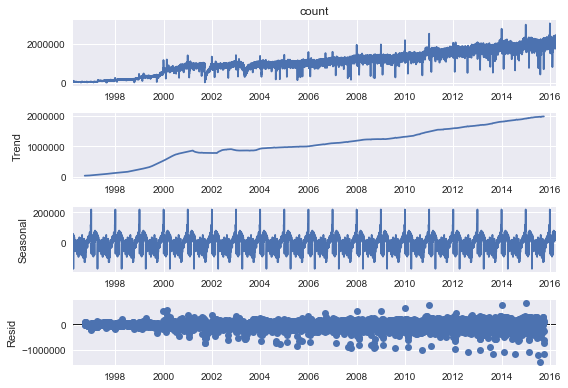

In [8]:
# The additive model is Y[t] = T[t] + S[t] + e[t]
from statsmodels.tsa.seasonal import seasonal_decompose
series = mrt.set_index('Date')['count'].copy()
result = seasonal_decompose(series, model='additive', period=365)
result.plot()
plt.show()

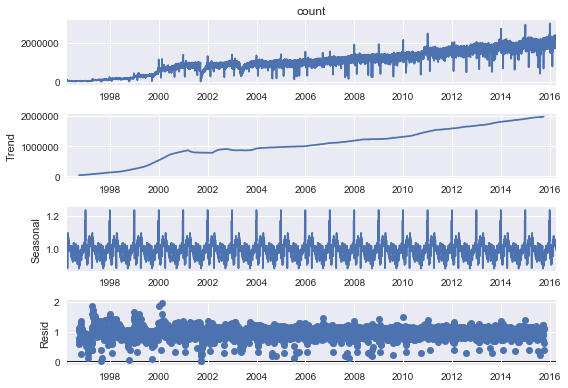

In [9]:
# Y[t] = T[t] * S[t] * e[t]
from statsmodels.tsa.seasonal import seasonal_decompose
series = mrt.set_index('Date')['count']
result = seasonal_decompose(series, model='multiplicative', period=365)
result.plot()
plt.show()

## Smoothing 

#### >> The Moving Average Method

* Forecast future points using an average of several past points.

* Forecast a series without no trend and no seasonality

__Centered moving average__ (MA) based on window centered around time _t_.

__Trailing moving average__ based on a window from time _t_ and backwards.

In [10]:
mrt.head()

,year,month,day_of_month,Date,count
0,1996,3,28,1996-03-28,42548
1,1996,3,29,1996-03-29,104443
2,1996,3,30,1996-03-30,98792
3,1996,3,31,1996-03-31,84931
4,1996,4,1,1996-04-01,50126


Centered MA is to compute average of values in window (of width $w$), centered at $t$

$w$ is odd: center window on time $t$ and average the values in the window


$$MA_{t} = \frac{ y_{t-2}+y_{t-1}+y_{t}+y_{t+1}+y_{t+2} }{5}, \: w=5$$

$$MA_{t} = \frac{1}{w}\sum_{i=-(w-1)/2}^{(w-1)/2} y_{t+i}$$



$w$ is even: take the "almost centered" windows and average values in them

$$MA_{right} = \frac{1}{w}\sum_{i=-w/2+1}^{w/2} y_{t+i}$$

$$MA_{left} = \frac{1}{w}\sum_{i=-w/2}^{w/2-1} y_{t+i}$$

$$MA_{t} = ({MA}_{right}+{MA}_{left})/2$$

Compute a Trailing MA 

$$MA_{t}= \frac{1}{w}\sum_{i=-w+1}^{0} y_{t+i}$$

In [11]:
amtrak = pd.read_csv('../data/Amtrak.csv')

In [12]:
amtrak.head()

,Month,Ridership
0,01/01/1991,1708.917
1,01/02/1991,1620.586
2,01/03/1991,1972.715
3,01/04/1991,1811.665
4,01/05/1991,1974.964


In [13]:
# convert Month to datetime object

#amtrak['Date'] = pd.to_datetime(amtrak['Month'].apply(lambda x: x.replace('/', '-')))
amtrak['Date'] = pd.to_datetime(amtrak['Month'], format='%d/%m/%Y')

In [14]:
amtrak.head()

,Month,Ridership,Date
0,01/01/1991,1708.917,1991-01-01
1,01/02/1991,1620.586,1991-02-01
2,01/03/1991,1972.715,1991-03-01
3,01/04/1991,1811.665,1991-04-01
4,01/05/1991,1974.964,1991-05-01


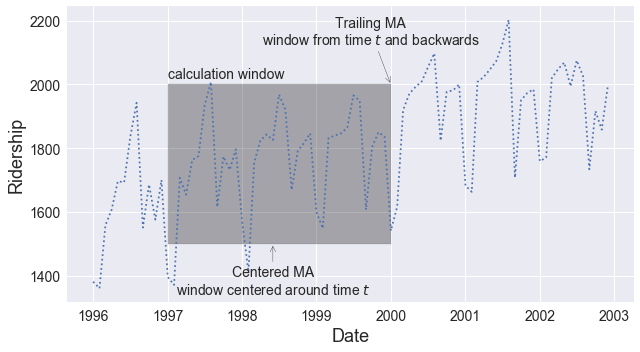

In [15]:
# illustration of moving average
from datetime import datetime, timedelta

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,5))

ax.plot(amtrak.set_index('Date').Ridership['1996':'2002'], linestyle=':')
xy = (datetime(1997,1,1,0,0,0), 1500)
rect = plt.Rectangle(xy, timedelta(days=3*365), 500, color='k', alpha=0.3 )

ax.add_patch(rect)

ax.annotate('Centered MA\nwindow centered around time $t$', 
            fontsize=14,
            ha='center', 
            xy=(datetime(1998,6,1,0,0,0), 1500),
            xytext=(-0, -50), textcoords="offset points",
            arrowprops=dict(arrowstyle="->", color='k'))

ax.annotate('Trailing MA\nwindow from time $t$ and backwards', 
            fontsize=14,
            ha='center',
            xy=(datetime(2000,1,1,0,0,0), 2000),
            xytext=(-20, 40), textcoords="offset points",
            arrowprops=dict(arrowstyle="->", color='k'))

ax.text(datetime(1997,1,1,0,0,0), 2020, 
        "calculation window", 
        fontsize=14)

ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Ridership', fontsize=18)
ax.tick_params(labelsize=14)

plt.tight_layout()
plt.show()
plt.close()

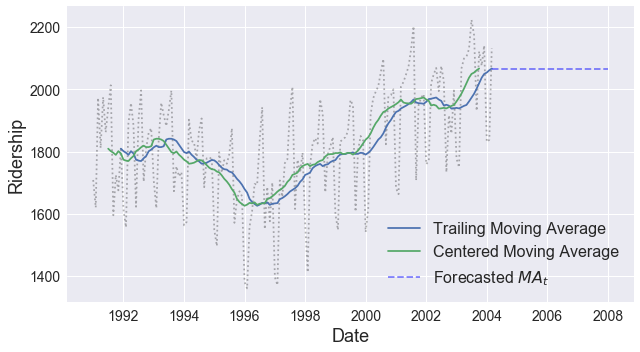

In [16]:
# visualisation of moving average

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,5))

ax.plot(amtrak.set_index('Date').Ridership, color='k',
        linestyle=':', alpha=0.3)

ax.plot(amtrak.
        set_index('Date').
        rolling(12).
        mean(), label='Trailing Moving Average' )

ax.plot(amtrak.
        set_index('Date').
        rolling(12, center=True).
        mean(), label='Centered Moving Average' )

f = amtrak.set_index('Date').rolling(12).mean().values[-1]
s = pd.Series({datetime(2004,3,1,0,0,0):f, datetime(2008,1,1,0,0,0):f})
ax.plot(s, color='b', linestyle='--', alpha=0.5, 
        label='Forecasted $MA_{t}$')

ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Ridership', fontsize=18)
ax.tick_params(labelsize=14)

plt.legend(fontsize=16)
plt.tight_layout()
plt.show()
plt.close()

To forecast at time $t+1$, given data until time $t$ use a trailing MA that ends at time $t$:

$$F_{t+1}=MA_{t} $$

__Note__ that forecasting further into the future yields the same forecast as a one-step-ahead forecast. Because forecast into the future rely only on information until the time prediction. Hence, the $k$-step ahead forecast is equal to

$$F_{t+k}=F_{t+1}$$

Longest window = over-smoothing

Shortest window = under-smoothing, no smoothing (naive forecasting)

#### >> Differencing

__Differencing__ means taking difference between two values of the series.

__Lag__ means how far apart these two values are


> Lag-1 differencing: $y_{t}-y_{t-1}$ // Useful for removing trends

> Lag-M differencing: $y_{t}-y_{t-M}$ // Useful for removing seasonality with $M$ seasons

> Double-differencing //Perform the differencing operation twice (difference the differenced series)

In [17]:
# add Lag-1 difference to the DataFrame
amtrak.loc[:, 'Lag1'] = np.nan
amtrak.loc[1:, 'Lag1'] = amtrak.Ridership.values[1:]-amtrak.Ridership.values[:-1]

# add Lag-12 difference to the DataFrame
amtrak.loc[:, 'Lag12'] = np.nan
amtrak.loc[12:, 'Lag12'] = amtrak.Ridership.values[12:]-amtrak.Ridership.values[:-12]

amtrak.head(20)

,Month,Ridership,Date,Lag1,Lag12
0,01/01/1991,1708.917,1991-01-01,NaN,NaN
1,01/02/1991,1620.586,1991-02-01,-88.331,NaN
2,01/03/1991,1972.715,1991-03-01,352.129,NaN
3,01/04/1991,1811.665,1991-04-01,-161.050,NaN
4,01/05/1991,1974.964,1991-05-01,163.299,NaN
5,01/06/1991,1862.356,1991-06-01,-112.608,NaN
6,01/07/1991,1939.860,1991-07-01,77.504,NaN
7,01/08/1991,2013.264,1991-08-01,73.404,NaN
8,01/09/1991,1595.657,1991-09-01,-417.607,NaN
9,01/10/1991,1724.924,1991-10-01,129.267,NaN


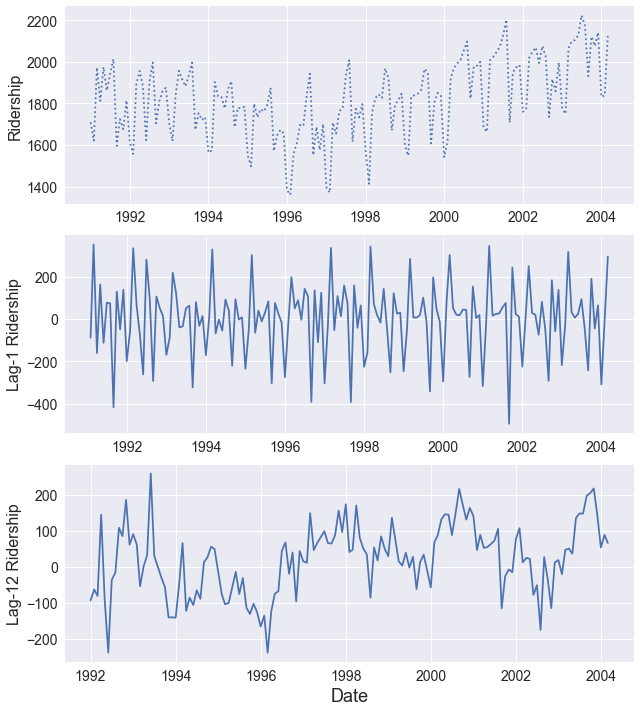

In [18]:
# visualisation of differences

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(9,10))

ax[0].plot(amtrak.set_index('Date').Ridership, linestyle=':')
ax[0].set_ylabel('Ridership', fontsize=16)
ax[0].tick_params(labelsize=14)

ax[1].plot(amtrak.set_index('Date').Lag1, linestyle='-')
ax[1].set_ylabel('Lag-1 Ridership', fontsize=16)
ax[1].tick_params(labelsize=14)

ax[2].plot(amtrak.set_index('Date').Lag12, linestyle='-')
ax[2].set_xlabel('Date', fontsize=18)
ax[2].set_ylabel('Lag-12 Ridership', fontsize=16)
ax[2].tick_params(labelsize=14)

plt.tight_layout()
plt.show()
plt.close()

Some forecasting methods are suitable only for series with no trends and no seasonality.


Differencing is a simple and popular method for removing a trend and/or a seasonality from time series. 

#### >> Simple Exponential Smoothing (SES)

* Forecast the future values using a weighted average of all previous values in a series.

* Forecast a series with no trend and no seasonality. Such series could be obtained by removing trend or/and seasonality from raw series. The SES method estimates the level.

* Cheap to compute.

$$F_{t+1} = \alpha Y_{t}+\alpha(\alpha-1) Y_{t-1} + \alpha(\alpha-1)^{2} Y_{t-2}+...$$

where $\alpha$ is constant between 0 and 1 called _smoothing parameter_

Exponential forecaster 

$$ F_{t+1}=F_{t}+\alpha E_{t}$$

where $E_{t}$ is the forecast error at time $t$

__Note__ that forecasting further into the future yields the same forecast as a one-step-ahead forecast. Because the series is assumed to lack trend and seasonality, forecast into the future rely only on information until the time prediction. Hence, the $k$-step ahead forecast is equal to

$$F_{t+k}=F_{t+1}$$

In [19]:
# Train, Test data sets
ridership = amtrak.set_index('Date')['Ridership'].copy()
Train = ridership[:'2000-12-01 00:00:00']
Test = ridership['2000-12-01 00:00:00':]

In [20]:
# set index frequency
Train.index = pd.DatetimeIndex(Train.index, freq=Train.index.inferred_freq)
Test.index = pd.DatetimeIndex(Test.index, freq=Test.index.inferred_freq)

In [21]:
# simple exponential model to forecast
from statsmodels.tsa.api import SimpleExpSmoothing

ses = SimpleExpSmoothing(Train).fit(smoothing_level=0.3, optimized=False)

forecasted = ses.forecast(Test.shape[0])

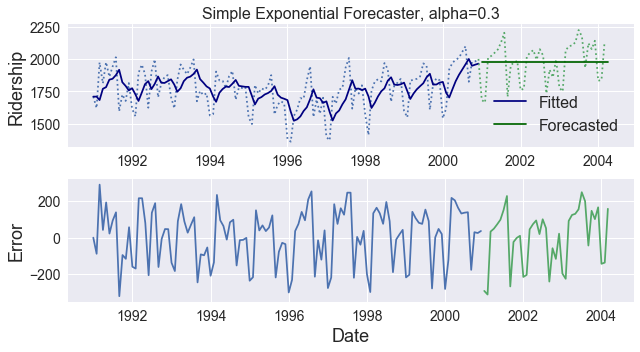

In [22]:
# Plot fitted/forecasted values using simple exponential forecaster
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(9,5))

ax[0].plot(Train, linestyle=':')
ax[0].plot(ses.fittedvalues, label='Fitted', color='navy')

ax[0].plot(Test, linestyle=':')
ax[0].plot(forecasted, label='Forecasted', color='darkgreen')

ax[0].set_xlabel(None)
ax[0].set_ylabel('Ridership', fontsize=18)
ax[0].tick_params(labelsize=14)

ax[0].legend(fontsize=16)
alpha = ses.params['smoothing_level']
ax[0].set_title(f'Simple Exponential Forecaster, alpha={alpha}', 
                fontsize=16)

ax[1].plot(ses.resid)
ax[1].plot(Test-forecasted)

ax[1].set_ylabel('Error', fontsize=18)
ax[1].set_xlabel('Date', fontsize=18)
ax[1].tick_params(labelsize=14)

plt.tight_layout()
plt.show()
plt.close()

In [23]:
# residual sum of squares (RSS), also known as 
# the sum of squared estimate of errors (SSE)

# Train
print(f'Train SSE = {ses.sse}')

# Test
print(f'Test SSE = {((Test-forecasted)**2).sum()}')



Train SSE = 2694624.333330793
Test SSE = 921206.6196174843


#### >> Holt's Exponential Smoothing

__Series with a Trend__

For series that contain a trend, we can use "double exponential smoothing." Trend shape is not assumed to be global, but rather, it can change over time. 

The _k-step-ahead forecast_ is given by combining the level $L_{t}$ estimate at time $t$ and the trend $T_{t}$ estimate at time $t$:


$$F_{t+k}=L_{t}+kT_{t} $$

The level and trend are updated through a pair of updating equations:

$$L_{t}=\alpha Y_{t}+(1-\alpha)(L_{t-1}+T_{t-1}) $$

$$T_{t}=\beta (L_{t} - L_{t-1}) + (1-\beta)T_{t-1} $$

Here there are two smoothing parameters, $\alpha$ and $\beta$ in the range $[0,1]$, which determine the rate of learning.


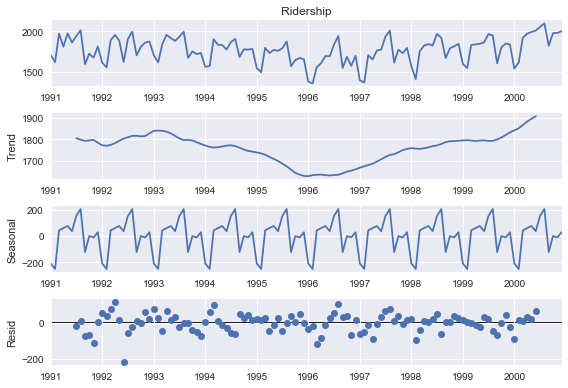

In [24]:
# The additive model is Y[t] = T[t] + S[t] + e[t]

result = seasonal_decompose(Train, model='additive')
result.plot()
plt.show()

In [67]:
# double exponential model (Holt's) to forecast
# include trend and no seasonality

# Holt(Train, damped=True)
# The damped trend method is a method 
# which add a dampening parameter so that 
# the trend converges to a constant value in the future 
#(for long forecast horizons) 

# .fit(optimized=True), smoothing_slope is otpimized 
# .fit(optimized=False), smoothing_slope is required to be given


from statsmodels.tsa.api import Holt

holt = Holt(Train).fit()

holt_forecasted = holt.forecast(Test.shape[0])

In [68]:
holt.params

{'smoothing_level': 0.17289462840961362,
 'smoothing_slope': 0.0,
 'smoothing_seasonal': nan,
 'damping_slope': nan,
 'initial_level': 1791.9362657848992,
 'initial_slope': 1.3445814681774175,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

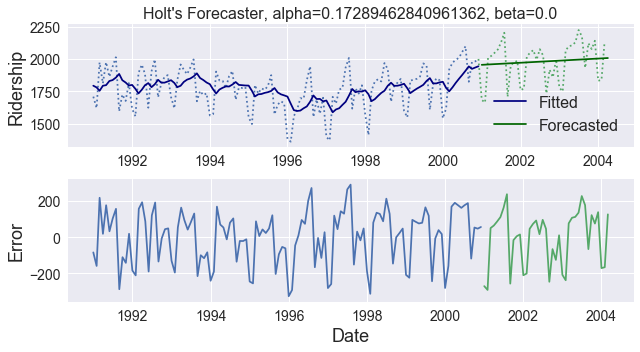

In [70]:
# Plot fitted/forecasted values using Holt's forecaster 

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(9,5))

ax[0].plot(Train, linestyle=':')
ax[0].plot(holt.fittedvalues, label='Fitted', color='navy')

ax[0].plot(Test, linestyle=':')
ax[0].plot(holt_forecasted, label='Forecasted', color='darkgreen')

ax[0].set_xlabel(None)
ax[0].set_ylabel('Ridership', fontsize=18)
ax[0].tick_params(labelsize=14)

ax[0].legend(fontsize=16)
alpha = holt.params['smoothing_level']
beta= holt.params['smoothing_slope']

ax[0].set_title(f"Holt's Forecaster, alpha={alpha}, beta={beta}", 
                fontsize=16)

ax[1].plot(holt.resid)
ax[1].plot(Test-holt_forecasted)

ax[1].set_ylabel('Error', fontsize=18)
ax[1].set_xlabel('Date', fontsize=18)
ax[1].tick_params(labelsize=14)

plt.tight_layout()
plt.show()
plt.close()

In [71]:
# residual sum of squares (RSS), also known as 
# the sum of squared estimate of errors (SSE)

# Train
print(f'Train SSE = {holt.sse}')

# Test
print(f'Test SSE = {((Test-holt_forecasted)**2).sum()}')

Train SSE = 2666420.2612451273
Test SSE = 882312.4411649142


#### >> Holt-Winter's Exponential Smoothing

__Series with a Trend and Seasonality__

This is a further extension of double exponential smoothing, where the _k-step-ahead forecast_ also takes into account the seasonality at period $t + k$. Assuming seasonality with $M$ seasons, the forecast is given by

$$F_{t+k} = (L_{t}+kT_{t})S_{t+k-M} $$

__Note__ that by the time of forecasting t, the series must have included at least one full cycle of seasons in order to produce forecasts using this formula, that is, $t > M$.

$$L_{t}=\alpha Y_{t} / S_{t-M}+(1-\alpha)(L_{t-1}+T_{t-1}) $$

$$T_{t}=\beta (L_{t} - L_{t-1}) + (1-\beta)T_{t-1} $$

$$S_{t} = \gamma Y_{t} / L_{t} + (1-\gamma)S_{t-M}$$




In [ ]:
# The additive model is Y[t] = T[t] + S[t] + e[t]

result = seasonal_decompose(Train, model='additive')
result.plot()
plt.show()

In [86]:
# Holt-Winter's model to forecast

# The damped trend method is a method 
# which add a dampening parameter so that 
# the trend converges to a constant value in the future 
#(for long forecast horizons) 

from statsmodels.tsa.api import ExponentialSmoothing

exp_smooth = ExponentialSmoothing(Train, 
                                  trend='additive',
                                  seasonal='additive',
                                  seasonal_periods=12, 
                                  damped=True
                                  ).fit(optimized=True)

#exp_smooth = ExponentialSmoothing(Train, 
#                                  trend='additive',
#                                  seasonal='additive',
#                                  seasonal_periods=12, 
#                                  damped=False
#                                  ).fit(smoothing_level=0.01, 
#                                        smoothing_slope=0.2, 
#                                        smoothing_seasonal=0.2
#                                       )

exp_forecasted = exp_smooth.forecast(Test.shape[0])

In [87]:
exp_smooth.params

{'smoothing_level': 0.5805883653891987,
 'smoothing_slope': 0.20188624214362116,
 'smoothing_seasonal': 0.0,
 'damping_slope': 0.0,
 'initial_level': 1644.3171973533165,
 'initial_slope': 0,
 'initial_seasons': array([ 47.78082718,   1.81175577, 300.77841357, 301.56818056,
        334.52039322, 289.29707364, 400.47170417, 451.21665536,
        129.95374488, 254.12600441, 245.00657067, 282.16169814]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

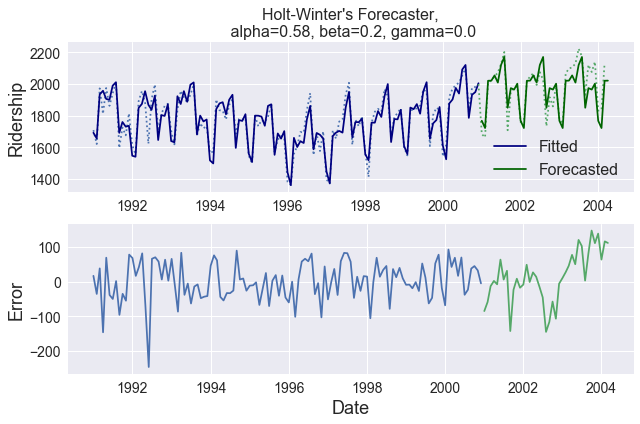

In [88]:
# Plot fitted/forecasted values using Holts-Winter's forecaster 

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(9,6))

ax[0].plot(Train, linestyle=':')
ax[0].plot(exp_smooth.fittedvalues, label='Fitted', color='navy')

ax[0].plot(Test, linestyle=':')
ax[0].plot(exp_forecasted, label='Forecasted', color='darkgreen')

ax[0].set_xlabel(None)
ax[0].set_ylabel('Ridership', fontsize=18)
ax[0].tick_params(labelsize=14)

ax[0].legend(fontsize=16)
alpha = exp_smooth.params['smoothing_level']
beta = exp_smooth.params['smoothing_slope']
gamma = exp_smooth.params['smoothing_seasonal']

ax[0].set_title(f"Holt-Winter's Forecaster,\n alpha={round(alpha,2)}, beta={round(beta,2)}, gamma={round(gamma,2)}", fontsize=16)

ax[1].plot(exp_smooth.resid)
ax[1].plot(Test-exp_forecasted)

ax[1].set_ylabel('Error', fontsize=18)
ax[1].set_xlabel('Date', fontsize=18)
ax[1].tick_params(labelsize=14)

plt.tight_layout()
plt.show()
plt.close()

In [89]:
# residual sum of squares (RSS), also known as 
# the sum of squared estimate of errors (SSE)

# Train
print(f'Train SSE = {exp_smooth.sse}')

# Test
print(f'Test SSE = {((Test-exp_forecasted)**2).sum()}')

Train SSE = 375805.7207066487
Test SSE = 218152.9082726551
